In [ ]:
# default_exp 
from nbdev.showdoc import *
import numpy as np
import torch
from directed_graphs.datasets import DirectedStochasticBlockModel
from directed_graphs.diffusion_flow_embedding import DiffusionFlowEmbedder
device = 'cpu'
# device = torch.device('mps' if torch.has_mps else 'cpu')
%load_ext autoreload
%autoreload 2
print("Using device ", device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device  cpu


# Testing the Diffusion Flow Embedder

The stochastic block models will be our best test cases here, as they provide enough points for diffusion to work, while still being interpretable.

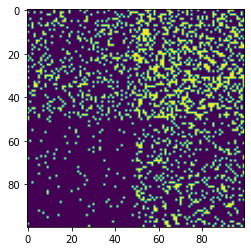

In [ ]:
import matplotlib.pyplot as plt
aij = np.array([[0.4,0.4],[0.4,0.4]])
bij = np.array([[0.5,0.9],[0.1,0.5]])
dataset = DirectedStochasticBlockModel(num_nodes=100, num_clusters=2, aij = aij, bij = bij)
data = dataset[0] # there is only graph in this dataset
sparse_A = torch.sparse_coo_tensor(data.edge_index,torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
plt.imshow(A)

In [ ]:
labels = 50*[0] + 50*[1]


In [ ]:
dfe = DiffusionFlowEmbedder(data,t=4,sigma=0.5)


In [ ]:
embeddings = dfe.fit(n_steps=1000)

100%|██████████| 1000/1000 [00:01<00:00, 788.02it/s]

Exiting training with loss  tensor(0.0163, grad_fn=<DivBackward0>)


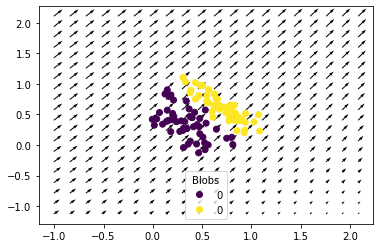

In [ ]:
dfe.visualize_points(labels)